# Simulator

In [1]:
import sys
sys.path.insert(0, "..")
import pandas as pd
import matplotlib.pyplot as plt
from trading_simulator import TradingSimulator, DLSimulator
from dl_solutions.dlsolutions import CryptoDLSolutions
from data_processor.data_processing import DataProcessor
from utils.crypto_utils import ModelAnalysis

Using TensorFlow backend.


## Classic

### Data preparation

In [ ]:
cryptos = ['ADA', 'BTC', 'ETH', 'LTC', 'LNK']
sel = 0

In [12]:
for crypto in cryptos:
    processor = DataProcessor([crypto])
    sim = TradingSimulator(processor, crypto, strategy = [1, 2, 3, 4, 5, 6, 7], loss_allowed = 0.2, log = False)
    sim.simulate()

Loading... ADA


KeyboardInterrupt: 

In [ ]:
processor = DataProcessor([crypto])
sim1 = TradingSimulator(processor, crypto, strategy = [1], loss_allowed = 0.2)
sim2 = TradingSimulator(processor, crypto, strategy = [2], loss_allowed = 0.2)
sim3 = TradingSimulator(processor, crypto, strategy = [3], loss_allowed = 0.2)
sim4 = TradingSimulator(processor, crypto, strategy = [4], loss_allowed = 0.2)
sim5 = TradingSimulator(processor, crypto, strategy = [5], loss_allowed = 0.2)
sim6 = TradingSimulator(processor, crypto, strategy = [6], loss_allowed = 0.2)
sim6 = TradingSimulator(processor, crypto, strategy = [7], loss_allowed = 0.2)
sim7 = TradingSimulator(processor, crypto, strategy = [1, 2, 3, 4, 5, 6, 7], loss_allowed = 0.2)

### Simulations

In [ ]:
sim1.simulate()

In [ ]:
sim2.simulate()

In [ ]:
sim3.simulate()

In [ ]:
sim4.simulate()

In [ ]:
sim5.simulate()

In [ ]:
sim6.simulate()

In [ ]:
sim7.simulate()

## DL Solution

In [2]:
model_analysis = ModelAnalysis()

### Data preparation

In [3]:
crypto = 'ETH'
periods_to_retraining = 1
prev_periods = 5
pred_periods = 10
model_selector = 'lstm'
columns = ['RSI', 'close']
#columns = ['weekday_num', 'RSI', 'MACD', 'close']
#columns = ['RSI', 'MACD', 'close']
#columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'RSI', 'MACD', 'close']
#columns = ['SO_K', 'SMA 50', 'SMA 200', 'close']
#columns = ['close']
num_features = len(columns)
target = None
#target = 'close'

norm_strat = 2
model_sel = 0
layers = 3
neurons = [50, 50, 50, 50]
batch_size = 64
epochs = 10
activations = ['relu', 'sigmoid']
losses = ['mse', 'binary_crossentropy']
activation = 'relu'
loss = 'mse'
metrics = ['mse']
optimizer = 'adam'
initial_learning_rate = 0.01

processor = DataProcessor([crypto])
sim = DLSimulator(crypto, prev_periods, pred_periods, columns, target,
norm_strat, model_sel, layers, neurons, batch_size, epochs, 
activation, loss, metrics, optimizer, initial_learning_rate)

#sim.simulate()
df_train = sim.get_df().iloc[:-1]
df_test = sim.get_df().iloc[-1:]

df_train

Loading... ETH
Extracting columns columns for ETH
Proccessing and arranging columns for LSTM model


,close_4,RSI_4,close_3,RSI_3,close_2,RSI_2,close_1,RSI_1,close_0,RSI_0,close,RSI
142,754.99,51.874455,855.28,64.086633,934.03,70.431522,940.00,70.851945,959.30,72.226781,1271.00,66.121951
143,855.28,64.086633,934.03,70.431522,940.00,70.851945,959.30,72.226781,1004.11,75.156684,1000.00,48.819684
144,934.03,70.431522,940.00,70.851945,959.30,72.226781,1004.11,75.156684,1123.09,80.914056,1000.00,48.819684
145,940.00,70.851945,959.30,72.226781,1004.11,75.156684,1123.09,80.914056,1133.18,81.309636,994.00,48.493851
146,959.30,72.226781,1004.11,75.156684,1123.09,80.914056,1133.18,81.309636,1291.00,86.146268,1032.50,50.764615
...,...,...,...,...,...,...,...,...,...,...,...,...
1583,4130.00,46.707531,3781.93,39.777252,3858.99,41.834910,4019.08,45.965427,3958.11,44.664534,4063.56,49.043455
1584,3781.93,39.777252,3858.99,41.834910,4019.08,45.965427,3958.11,44.664534,3875.42,42.891556,4037.23,48.110387
1585,3858.99,41.834910,4019.08,45.965427,3958.11,44.664534,3875.42,42.891556,3959.93,45.282169,3792.75,40.420633
1586,4019.08,45.965427,3958.11,44.664534,3875.42,42.891556,3959.93,45.282169,3924.14,44.433846,3630.19,36.269469


### DL parameters and training

Creation of different strategies:

- Based on result
- Based on close/indicators
- Try with different close distances
- Multioutput
- Based on multiple operation (softmax)

In [4]:
sim.train_model(df_train)

Input shape: (1446, 5, 2) (1446, 2) (0, 5, 2) (0, 2)
Y shape (1446, 2)
Train on 1446 samples, validate on 73 samples
Epoch 1/10
 - 9s - loss: 0.0837 - mse: 0.0837 - val_loss: 0.2307 - val_mse: 0.2307
Epoch 2/10
 - 1s - loss: 0.0677 - mse: 0.0677 - val_loss: 0.2142 - val_mse: 0.2142
Epoch 3/10
 - 1s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.2143 - val_mse: 0.2143
Epoch 4/10
 - 1s - loss: 0.0480 - mse: 0.0480 - val_loss: 0.1780 - val_mse: 0.1780
Epoch 5/10
 - 2s - loss: 0.0436 - mse: 0.0436 - val_loss: 0.1207 - val_mse: 0.1207
Epoch 6/10
 - 1s - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0524 - val_mse: 0.0524
Epoch 7/10
 - 1s - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 8/10
 - 1s - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 9/10
 - 1s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.1822 - val_mse: 0.1822
Epoch 10/10
 - 1s - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0205 - val_mse: 0.0205


### Test

In [5]:
df_test

,close_4,RSI_4,close_3,RSI_3,close_2,RSI_2,close_1,RSI_1,close_0,RSI_0,close,RSI
1588,3875.42,42.891556,3959.93,45.282169,3924.14,44.433846,3944.73,45.071392,4014.15,47.268176,3725.46,40.196471


In [6]:
pred = sim.predict(pd.DataFrame(df_test))
print('Predictions', pred)

real [[3725.46         40.19647068]]
Test RMSE: 112.196
Predictions [[3883.81541054   50.17730099]]


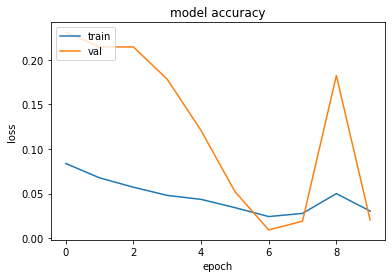

In [7]:
h = sim.get_history()

model_analysis.draw_history(h)

#### LSTM

##### Multiples features

Periods analysis

- Different previous periods used
- Different number of future periods to predict

For each period parameters used:

- Different metrics used
- Different hiper parameters
    - Different stretegies

##### One line feature

#### GRU

## Complete simulation

Complete strategy definition. Let the machine work through all the dataset